## Updates

- I have added code that does model prediction visualization by putting it in camera frame. I found this to be more intuitive than visualizing it in lidar frame.
I hope you find it useful.

If you check out the reference model in [lyft devkit](https://github.com/lyft/nuscenes-devkit/tree/master/notebooks), you will find that they are using map masks for training UNET. The map masks are first extracted around the corresponding ego region and used as 3 additional channels. This seems to be give some improvement in lb score.

In this notebook i do inference using such a trained trained model.
I have extracted the ego centered maps and made a test dataset. You can find it [here](https://www.kaggle.com/meaninglesslives/lyft3d-mask-test-data). It takes a long time to compute on test set, so i am sharing it here :-D


# Install the Lyft SDK

In [1]:
!pip install lyft-dataset-sdk -q
!pip install moviepy

     |████████████████████████████████| 378kB 9.5MB/s 
     |████████████████████████████████| 22.2MB 40.2MB/s 
  Created wheel for moviepy: filename=moviepy-1.0.1-cp36-none-any.whl size=110786 sha256=4c0922030d2cf992df93751237d8218ec378fb512754c437660c404f9db4815a
  Stored in directory: /tmp/.cache/pip/wheels/a3/3c/07/45afe2bd5dbd3f935f445545d645f0f8c05d48340136367d45
  Created wheel for proglog: filename=proglog-0.1.9-cp36-none-any.whl size=6148 sha256=8187d79d914aa8b0c1e1d324046d517b6a7afcf273af20b335ded30a0f6eb1e6
  Stored in directory: /tmp/.cache/pip/wheels/65/56/60/1d0306a8d90b188af393c1812ddb502a8821b70917f82dcc00
Successfully built moviepy proglog


In [2]:
from datetime import datetime
from functools import partial
import glob
from multiprocessing import Pool

# Disable multiprocesing for numpy/opencv. We already multiprocess ourselves, this would mean every subprocess produces
# even more threads which would lead to a lot of context switching, slowing things down a lot.
import os
os.environ["OMP_NUM_THREADS"] = "1"

import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import cv2
from PIL import Image
import numpy as np
from tqdm import tqdm, tqdm_notebook
import scipy
import scipy.ndimage
import scipy.special
from scipy.spatial.transform import Rotation as R

from lyft_dataset_sdk.lyftdataset import LyftDataset
from lyft_dataset_sdk.utils.data_classes import LidarPointCloud, Box, Quaternion
from lyft_dataset_sdk.utils.geometry_utils import view_points, transform_matrix

import time
from lyft_dataset_sdk.utils.map_mask import MapMask
from pathlib import Path
from lyft_dataset_sdk.lyftdataset import LyftDataset,LyftDatasetExplorer

# Lyft SDK requires creating a link to input folders

In [3]:
!ln -s /kaggle/input/3d-object-detection-for-autonomous-vehicles/test_images images
!ln -s /kaggle/input/3d-object-detection-for-autonomous-vehicles/test_maps maps
!ln -s /kaggle/input/3d-object-detection-for-autonomous-vehicles/test_lidar lidar

In [4]:
classes = ["car", "motorcycle", "bus", "bicycle", "truck", "pedestrian", "other_vehicle", "animal", "emergency_vehicle"]
train_dataset = LyftDataset(data_path='.', json_path='../input/3d-object-detection-for-autonomous-vehicles/train_data', verbose=True)

9 category,
18 attribute,
4 visibility,
18421 instance,
10 sensor,
148 calibrated_sensor,
177789 ego_pose,
180 log,
180 scene,
22680 sample,
189504 sample_data,
638179 sample_annotation,
1 map,
Done loading in 13.0 seconds.
Reverse indexing ...
Done reverse indexing in 5.3 seconds.


# Find the mean height of all categories
We can use the mean height instead of blindly using 1.75m for all categories

In [5]:
train_dataset.list_categories()
del train_dataset;

Category stats
animal                      n=  186, width= 0.36±0.12, len= 0.73±0.19, height= 0.51±0.16, lw_aspect= 2.16±0.56
bicycle                     n=20928, width= 0.63±0.24, len= 1.76±0.29, height= 1.44±0.37, lw_aspect= 3.20±1.17
bus                         n= 8729, width= 2.96±0.24, len=12.34±3.41, height= 3.44±0.31, lw_aspect= 4.17±1.10
car                         n=534911, width= 1.93±0.16, len= 4.76±0.53, height= 1.72±0.24, lw_aspect= 2.47±0.22
emergency_vehicle           n=  132, width= 2.45±0.43, len= 6.52±1.44, height= 2.39±0.59, lw_aspect= 2.66±0.28
motorcycle                  n=  818, width= 0.96±0.20, len= 2.35±0.22, height= 1.59±0.16, lw_aspect= 2.53±0.50
other_vehicle               n=33376, width= 2.79±0.30, len= 8.20±1.71, height= 3.23±0.50, lw_aspect= 2.93±0.53
pedestrian                  n=24935, width= 0.77±0.14, len= 0.81±0.17, height= 1.78±0.16, lw_aspect= 1.06±0.20
truck                       n=14164, width= 2.84±0.32, len=10.24±4.09, height= 3.44±0.62, lw_asp

In [6]:
class_heights = {'animal':0.51,'bicycle':1.44,'bus':3.44,'car':1.72,'emergency_vehicle':2.39,'motorcycle':1.59,
                'other_vehicle':3.23,'pedestrian':1.78,'truck':3.44}
level5data = LyftDataset(data_path='.', json_path='../input/3d-object-detection-for-autonomous-vehicles/test_data', verbose=True)

JSON file instance.json missing, using empty list
JSON file sample_annotation.json missing, using empty list
9 category,
17 attribute,
4 visibility,
0 instance,
8 sensor,
168 calibrated_sensor,
219744 ego_pose,
218 log,
218 scene,
27468 sample,
219744 sample_data,
0 sample_annotation,
1 map,
Done loading in 3.0 seconds.
Reverse indexing ...
Done reverse indexing in 1.6 seconds.


In [7]:
def move_boxes_to_car_space(boxes, ego_pose):
    """
    Move boxes from world space to car space.
    Note: mutates input boxes.
    """
    translation = -np.array(ego_pose['translation'])
    rotation = Quaternion(ego_pose['rotation']).inverse
    
    for box in boxes:
        # Bring box to car space
        box.translate(translation)
        box.rotate(rotation)
        
def scale_boxes(boxes, factor):
    """
    Note: mutates input boxes
    """
    for box in boxes:
        box.wlh = box.wlh * factor

def draw_boxes(im, voxel_size, boxes, classes, z_offset=0.0):
    for box in boxes:
        # We only care about the bottom corners
        corners = box.bottom_corners()
        corners_voxel = car_to_voxel_coords(corners, im.shape, voxel_size, z_offset).transpose(1,0)
        corners_voxel = corners_voxel[:,:2] # Drop z coord

        class_color = classes.index(box.name) + 1
        
        if class_color == 0:
            raise Exception("Unknown class: {}".format(box.name))

        cv2.drawContours(im, np.int0([corners_voxel]), 0, (class_color, class_color, class_color), -1)

In [8]:
# Some hyperparameters we'll need to define for the system
voxel_size = (0.4, 0.4, 1.5)
z_offset = -2.0
bev_shape = (336, 336, 3)

# We scale down each box so they are more separated when projected into our coarse voxel space.
box_scale = 0.8

In [9]:
records = [(level5data.get('sample', record['first_sample_token'])['timestamp'], record) for record in level5data.scene]

entries = []

for start_time, record in sorted(records):
    start_time = level5data.get('sample', record['first_sample_token'])['timestamp'] / 1000000

    token = record['token']
    name = record['name']
    date = datetime.utcfromtimestamp(start_time)
    host = "-".join(record['name'].split("-")[:2])
    first_sample_token = record["first_sample_token"]

    entries.append((host, name, date, token, first_sample_token))
            
df = pd.DataFrame(entries, columns=["host", "scene_name", "date", "scene_token", "first_sample_token"])

In [10]:
df.head()

,host,scene_name,date,scene_token,first_sample_token
0,host-a007,host-a007-lidar0-1230678335199240106-123067836...,2019-01-04 23:05:35.302051,582583077b5db62b9b95d780c7fb3214f2fb6680ec61ef...,57b51d24fad1c39065f80c9f769b3ff8d29e17e0cf92f5...
1,host-a007,host-a007-lidar0-1230931253199029066-123093127...,2019-01-07 21:20:53.301923,795a318208bdc612f92eabe3af3102f9e55db4b6c1e44e...,780168b66b14e7f826b365d7f5f0ec602d70fc5df4edb9...
2,host-a007,host-a007-lidar0-1230939239197974066-123093926...,2019-01-07 23:33:59.300673,84ae53a19295800de1565ea5e61ef0d5e3d938a4b0601c...,99e78fc0682700b8be3635ef06231d813951d038e48795...
3,host-a009,host-a009-lidar0-1231184014198521956-123118403...,2019-01-10 19:33:34.301170,225300b10634526aafdce9bb3e00e863b24663e6766041...,c88dfa9d87d41079250dd7488f9ee3721dfda7e5b45563...
4,host-a008,host-a008-lidar0-1231272360198562866-123127238...,2019-01-11 20:06:00.301206,07b333dad30191a7d3048919c420083a7f53296b885038...,2299492f339a64c15d192e1b9ac3836917fb77660a4d72...


In [11]:
# sample_sub = pd.read_csv('../input/3d-object-detection-for-autonomous-vehicles/sample_submission.csv')
all_sample_tokens,scene_len = [],[]
for sample_token in tqdm_notebook(df.first_sample_token.values):
    i = 0
    while sample_token:
        all_sample_tokens.append(sample_token)
        sample = level5data.get("sample", sample_token)
        sample_token = sample["next"]
        i += 1
    scene_len.append(i)
#     print(len(all_sample_tokens[-1]))
    
print('Total number of tokens=',len(all_sample_tokens))


Total number of tokens= 27468


In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data

test_data_folder = '../input/lyft3d-mask-test-data/test_data/test_data'

class BEVImageDataset(torch.utils.data.Dataset):
    def __init__(self, sample_token,test_data_folder):

        self.sample_token = sample_token
        self.test_data_folder = test_data_folder

    def __len__(self):
        return len(self.sample_token)

    def __getitem__(self, idx):
        sample_token = self.sample_token[idx]
        
#         sample_token = input_filepath.split("/")[-1].replace("_input.png","")
        
        input_filepath = os.path.join(test_data_folder,f"{sample_token}_input.png")

        map_filepath = os.path.join(test_data_folder,f"{sample_token}_map.png")
        
        
        im = cv2.imread(input_filepath, cv2.IMREAD_UNCHANGED)
        
        map_im = cv2.imread(map_filepath, cv2.IMREAD_UNCHANGED)
#         print(im.shape,map_im.shape)
        im = np.concatenate((im, map_im), axis=2)
        
        im = im.astype(np.float32)/255
        
        im = torch.from_numpy(im.transpose(2,0,1))
        
        return im, sample_token

    
# input_filepaths = sorted(glob.glob(os.path.join(test_data_folder, "*_input.png")))
# map_filepaths = sorted(glob.glob(os.path.join(test_data_folder, "*_map.png")))

test_dataset = BEVImageDataset(all_sample_tokens,test_data_folder)

In [13]:
# test_dataset[0]

# Unet Model

In [14]:
# This implementation was copied from https://github.com/jvanvugt/pytorch-unet, it is MIT licensed.

class UNet(nn.Module):
    def __init__(
        self,
        in_channels=1,
        n_classes=2,
        depth=5,
        wf=6,
        padding=False,
        batch_norm=False,
        up_mode='upconv',
    ):
        """
        Implementation of
        U-Net: Convolutional Networks for Biomedical Image Segmentation
        (Ronneberger et al., 2015)
        https://arxiv.org/abs/1505.04597
        Using the default arguments will yield the exact version used
        in the original paper
        Args:
            in_channels (int): number of input channels
            n_classes (int): number of output channels
            depth (int): depth of the network
            wf (int): number of filters in the first layer is 2**wf
            padding (bool): if True, apply padding such that the input shape
                            is the same as the output.
                            This may introduce artifacts
            batch_norm (bool): Use BatchNorm after layers with an
                               activation function
            up_mode (str): one of 'upconv' or 'upsample'.
                           'upconv' will use transposed convolutions for
                           learned upsampling.
                           'upsample' will use bilinear upsampling.
        """
        super(UNet, self).__init__()
        assert up_mode in ('upconv', 'upsample')
        self.padding = padding
        self.depth = depth
        prev_channels = in_channels
        self.down_path = nn.ModuleList()
        for i in range(depth):
            self.down_path.append(
                UNetConvBlock(prev_channels, 2 ** (wf + i), padding, batch_norm)
            )
            prev_channels = 2 ** (wf + i)

        self.up_path = nn.ModuleList()
        for i in reversed(range(depth - 1)):
            self.up_path.append(
                UNetUpBlock(prev_channels, 2 ** (wf + i), up_mode, padding, batch_norm)
            )
            prev_channels = 2 ** (wf + i)

        self.last = nn.Conv2d(prev_channels, n_classes, kernel_size=1)

    def forward(self, x):
        blocks = []
        for i, down in enumerate(self.down_path):
            x = down(x)
            if i != len(self.down_path) - 1:
                blocks.append(x)
                x = F.max_pool2d(x, 2)

        for i, up in enumerate(self.up_path):
            x = up(x, blocks[-i - 1])

        return self.last(x)


class UNetConvBlock(nn.Module):
    def __init__(self, in_size, out_size, padding, batch_norm):
        super(UNetConvBlock, self).__init__()
        block = []

        block.append(nn.Conv2d(in_size, out_size, kernel_size=3, padding=int(padding)))
        block.append(nn.ReLU())
        if batch_norm:
            block.append(nn.BatchNorm2d(out_size))

        block.append(nn.Conv2d(out_size, out_size, kernel_size=3, padding=int(padding)))
        block.append(nn.ReLU())
        if batch_norm:
            block.append(nn.BatchNorm2d(out_size))

        self.block = nn.Sequential(*block)

    def forward(self, x):
        out = self.block(x)
        return out


class UNetUpBlock(nn.Module):
    def __init__(self, in_size, out_size, up_mode, padding, batch_norm):
        super(UNetUpBlock, self).__init__()
        if up_mode == 'upconv':
            self.up = nn.ConvTranspose2d(in_size, out_size, kernel_size=2, stride=2)
        elif up_mode == 'upsample':
            self.up = nn.Sequential(
                nn.Upsample(mode='bilinear', scale_factor=2),
                nn.Conv2d(in_size, out_size, kernel_size=1),
            )

        self.conv_block = UNetConvBlock(in_size, out_size, padding, batch_norm)

    def center_crop(self, layer, target_size):
        _, _, layer_height, layer_width = layer.size()
        diff_y = (layer_height - target_size[0]) // 2
        diff_x = (layer_width - target_size[1]) // 2
        return layer[
            :, :, diff_y : (diff_y + target_size[0]), diff_x : (diff_x + target_size[1])
        ]

    def forward(self, x, bridge):
        up = self.up(x)
        crop1 = self.center_crop(bridge, up.shape[2:])
        out = torch.cat([up, crop1], 1)
        out = self.conv_block(out)

        return out

We train a U-net fully convolutional neural network, we create a network that is less deep and with only half the amount of filters compared to the original U-net paper implementation. We do this to keep training and inference time low.

In [15]:
def get_unet_model(in_channels=6, num_output_classes=2):
    model = UNet(in_channels=in_channels, n_classes=num_output_classes, wf=5, depth=4, padding=True, up_mode='upsample')
    
    # Optional, for multi GPU training and inference
    model = nn.DataParallel(model)
    return model


In [16]:
def box_in_image(box, intrinsic, image_size) -> bool:
    """Check if a box is visible inside an image without accounting for occlusions.
    Args:
        box: The box to be checked.
        intrinsic: <float: 3, 3>. Intrinsic camera matrix.
        image_size: (width, height)
        vis_level: One of the enumerations of <BoxVisibility>.
    Returns: True if visibility condition is satisfied.
    """

    corners_3d = box.corners()
    corners_img = view_points(corners_3d, intrinsic, normalize=True)[:2, :]

    visible = np.logical_and(corners_img[0, :] > 0, corners_img[0, :] < image_size[0])
    visible = np.logical_and(visible, corners_img[1, :] < image_size[1])
    visible = np.logical_and(visible, corners_img[1, :] > 0)
    visible = np.logical_and(visible, corners_3d[2, :] > 1)

    in_front = corners_3d[2, :] > 0.1  # True if a corner is at least 0.1 meter in front of the camera.

    return any(visible) and all(in_front)

all_pred_fn = []
def viz_unet(sample_token,boxes): 

    sample = level5data.get("sample", sample_token)

    sample_camera_token = sample["data"]["CAM_FRONT"]
    camera_data = level5data.get("sample_data", sample_camera_token)
    # camera_filepath = level5data.get_sample_data_path(sample_camera_token)

    ego_pose = level5data.get("ego_pose", camera_data["ego_pose_token"])
    calibrated_sensor = level5data.get("calibrated_sensor", camera_data["calibrated_sensor_token"])
    data_path, _, camera_intrinsic = level5data.get_sample_data(sample_camera_token)


    data = Image.open(data_path)
    _, axis = plt.subplots(1, 1, figsize=(9, 9))
    
    for i,box in enumerate(boxes):

        # Move box to ego vehicle coord system
        box.translate(-np.array(ego_pose["translation"]))
        box.rotate(Quaternion(ego_pose["rotation"]).inverse)

        # Move box to sensor coord system
        box.translate(-np.array(calibrated_sensor["translation"]))
        box.rotate(Quaternion(calibrated_sensor["rotation"]).inverse)

        if box_in_image(box,camera_intrinsic,np.array(data).shape):            
            box.render(axis,camera_intrinsic,normalize=True)

    axis.imshow(data)
    all_pred_fn.append(f'./cam_viz/cam_preds_{sample_token}.jpg')
    plt.savefig(all_pred_fn[-1])
    plt.close()

In [17]:
# We weigh the loss for the 0 class lower to account for (some of) the big class imbalance.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class_weights = torch.from_numpy(np.array([0.2] + [1.0]*len(classes), dtype=np.float32))
class_weights = class_weights.to(device)

# Loading trained Unet model

In [18]:
# del model
batch_size = 8
epochs = 15 # Note: We may be able to train for longer and expect better results, the reason this number is low is to keep the runtime short.

model = get_unet_model(num_output_classes=len(classes)+1)

state = torch.load('../input/lyft3d-mask-test-data/unet_checkpoint_epoch_10.pth', map_location=lambda storage, loc: storage)
model.load_state_dict(state)
model = model.to(device)
model.eval();


In [19]:
def calc_detection_box(prediction_opened,class_probability):

    sample_boxes = []
    sample_detection_scores = []
    sample_detection_classes = []
    
    contours, hierarchy = cv2.findContours(prediction_opened, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
    
    for cnt in contours:
        rect = cv2.minAreaRect(cnt)
        box = cv2.boxPoints(rect)
        
        # Let's take the center pixel value as the confidence value
        box_center_index = np.int0(np.mean(box, axis=0))
        
        for class_index in range(len(classes)):
            box_center_value = class_probability[class_index+1, box_center_index[1], box_center_index[0]]
            
            # Let's remove candidates with very low probability
            if box_center_value < 0.01:
                continue
            
            box_center_class = classes[class_index]

            box_detection_score = box_center_value
            sample_detection_classes.append(box_center_class)
            sample_detection_scores.append(box_detection_score)
            sample_boxes.append(box)
            
    return np.array(sample_boxes),sample_detection_scores,sample_detection_classes

In [20]:
# We perform an opening morphological operation to filter tiny detections
# Note that this may be problematic for classes that are inherently small (e.g. pedestrians)..
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
    
def open_preds(predictions_non_class0):

    predictions_opened = np.zeros((predictions_non_class0.shape), dtype=np.uint8)

    for i, p in enumerate(tqdm(predictions_non_class0)):
        thresholded_p = (p > background_threshold).astype(np.uint8)
        predictions_opened[i] = cv2.morphologyEx(thresholded_p, cv2.MORPH_OPEN, kernel)
        
    return predictions_opened

# Test Set Predictions

In [21]:
import gc
gc.collect()
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=False, num_workers=os.cpu_count()*2)
progress_bar = tqdm_notebook(test_loader)

# We quantize to uint8 here to conserve memory. We're allocating >20GB of memory otherwise.
# predictions = np.zeros((len(test_loader), 1+len(classes), 336, 336), dtype=np.uint8)

sample_tokens = []
all_losses = []

detection_boxes = []
detection_scores = []
detection_classes = []

# Arbitrary threshold in our system to create a binary image to fit boxes around.
background_threshold = 225

with torch.no_grad():
    model.eval()
    for ii, (X, batch_sample_tokens) in enumerate(progress_bar):

        sample_tokens.extend(batch_sample_tokens)
        
        X = X.to(device)  # [N, 1, H, W]
        prediction = model(X)  # [N, 2, H, W]
        
        prediction = F.softmax(prediction, dim=1)
        
        prediction_cpu = prediction.cpu().numpy()
        predictions = np.round(prediction_cpu*255).astype(np.uint8)
        
        # Get probabilities for non-background
        predictions_non_class0 = 255 - predictions[:,0]
        
        predictions_opened = np.zeros((predictions_non_class0.shape), dtype=np.uint8)

        for i, p in enumerate(predictions_non_class0):
            thresholded_p = (p > background_threshold).astype(np.uint8)
            predictions_opened[i] = cv2.morphologyEx(thresholded_p, cv2.MORPH_OPEN, kernel)
    
            sample_boxes,sample_detection_scores,sample_detection_classes = calc_detection_box(predictions_opened[i],
                                                                                              predictions[i])
        
            detection_boxes.append(np.array(sample_boxes))
            detection_scores.append(sample_detection_scores)
            detection_classes.append(sample_detection_classes)
        
#         # Visualize the first prediction
#         if ii == 0:
#             visualize_predictions(X, prediction, apply_softmaxiii=False)
            

/opt/conda/lib/python3.6/site-packages/torch/nn/functional.py:2479: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Total amount of boxes: 684746


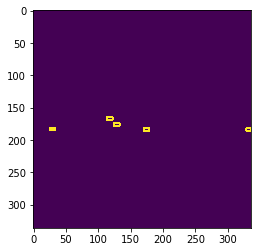

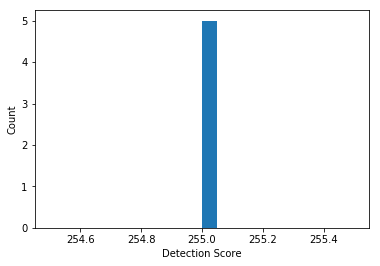

In [22]:
print("Total amount of boxes:", np.sum([len(x) for x in detection_boxes]))
    

# Visualize the boxes in the first sample
t = np.zeros_like(predictions_opened[0])
for sample_boxes in detection_boxes[0]:
    box_pix = np.int0(sample_boxes)
    cv2.drawContours(t,[box_pix],0,(255),2)
plt.imshow(t)
plt.show()

# Visualize their probabilities
plt.hist(detection_scores[0], bins=20)
plt.xlabel("Detection Score")
plt.ylabel("Count")
plt.show()

# Transform predicted boxes back into world space

In [23]:
def create_transformation_matrix_to_voxel_space(shape, voxel_size, offset):
    """
    Constructs a transformation matrix given an output voxel shape such that (0,0,0) ends up in the center.
    Voxel_size defines how large every voxel is in world coordinate, (1,1,1) would be the same as Minecraft voxels.
    
    An offset per axis in world coordinates (metric) can be provided, this is useful for Z (up-down) in lidar points.
    """
    
    shape, voxel_size, offset = np.array(shape), np.array(voxel_size), np.array(offset)
    
    tm = np.eye(4, dtype=np.float32)
    translation = shape/2 + offset/voxel_size
    
    tm = tm * np.array(np.hstack((1/voxel_size, [1])))
    tm[:3, 3] = np.transpose(translation)
    return tm

def transform_points(points, transf_matrix):
    """
    Transform (3,N) or (4,N) points using transformation matrix.
    """
    if points.shape[0] not in [3,4]:
        raise Exception("Points input should be (3,N) or (4,N) shape, received {}".format(points.shape))
    return transf_matrix.dot(np.vstack((points[:3, :], np.ones(points.shape[1]))))[:3, :]


def car_to_voxel_coords(points, shape, voxel_size, z_offset=0):
    if len(shape) != 3:
        raise Exception("Voxel volume shape should be 3 dimensions (x,y,z)")
        
    if len(points.shape) != 2 or points.shape[0] not in [3, 4]:
        raise Exception("Input points should be (3,N) or (4,N) in shape, found {}".format(points.shape))

    tm = create_transformation_matrix_to_voxel_space(shape, voxel_size, (0, 0, z_offset))
    p = transform_points(points, tm)
    return p

def create_voxel_pointcloud(points, shape, voxel_size=(0.5,0.5,1), z_offset=0):

    points_voxel_coords = car_to_voxel_coords(points.copy(), shape, voxel_size, z_offset)
    points_voxel_coords = points_voxel_coords[:3].transpose(1,0)
    points_voxel_coords = np.int0(points_voxel_coords)
    
    bev = np.zeros(shape, dtype=np.float32)
    bev_shape = np.array(shape)

    within_bounds = (np.all(points_voxel_coords >= 0, axis=1) * np.all(points_voxel_coords < bev_shape, axis=1))
    
    points_voxel_coords = points_voxel_coords[within_bounds]
    coord, count = np.unique(points_voxel_coords, axis=0, return_counts=True)
        
    # Note X and Y are flipped:
    bev[coord[:,1], coord[:,0], coord[:,2]] = count
    
    return bev

def normalize_voxel_intensities(bev, max_intensity=16):
    return (bev/max_intensity).clip(0,1)


In [24]:
os.makedirs('./cam_viz',exist_ok=True)

from moviepy.editor import ImageSequenceClip 
from lyft_dataset_sdk.eval.detection.mAP_evaluation import Box3D, recall_precision
import shutil

pred_box3ds = []

max_frames = 128
vid_count = 0
processed_samples = 0
for (sample_token, sample_boxes, sample_detection_scores, sample_detection_class) in tqdm_notebook(zip(sample_tokens, detection_boxes, detection_scores, detection_classes), total=len(sample_tokens)):
    processed_samples += 1
    sample_boxes = sample_boxes.reshape(-1, 2) # (N, 4, 2) -> (N*4, 2)
    sample_boxes = sample_boxes.transpose(1,0) # (N*4, 2) -> (2, N*4)

    # Add Z dimension
    sample_boxes = np.vstack((sample_boxes, np.zeros(sample_boxes.shape[1]),)) # (2, N*4) -> (3, N*4)

    sample = level5data.get("sample", sample_token)
    sample_lidar_token = sample["data"]["LIDAR_TOP"]
    lidar_data = level5data.get("sample_data", sample_lidar_token)
    lidar_filepath = level5data.get_sample_data_path(sample_lidar_token)
    ego_pose = level5data.get("ego_pose", lidar_data["ego_pose_token"])
    ego_translation = np.array(ego_pose['translation'])

    global_from_car = transform_matrix(ego_pose['translation'],
                                       Quaternion(ego_pose['rotation']), inverse=False)

    car_from_voxel = np.linalg.inv(create_transformation_matrix_to_voxel_space(bev_shape, voxel_size, (0, 0, z_offset)))


    global_from_voxel = np.dot(global_from_car, car_from_voxel)
    sample_boxes = transform_points(sample_boxes, global_from_voxel)

    # We don't know at where the boxes are in the scene on the z-axis (up-down), let's assume all of them are at
    # the same height as the ego vehicle.
    sample_boxes[2,:] = ego_pose["translation"][2]


    # (3, N*4) -> (N, 4, 3)
    sample_boxes = sample_boxes.transpose(1,0).reshape(-1, 4, 3)

#     box_height = 1.75
    box_height = np.array([class_heights[cls] for cls in sample_detection_class])

    # Note: Each of these boxes describes the ground corners of a 3D box.
    # To get the center of the box in 3D, we'll have to add half the height to it.
    sample_boxes_centers = sample_boxes.mean(axis=1)
    sample_boxes_centers[:,2] += box_height/2

    # Width and height is arbitrary - we don't know what way the vehicles are pointing from our prediction segmentation
    # It doesn't matter for evaluation, so no need to worry about that here.
    # Note: We scaled our targets to be 0.8 the actual size, we need to adjust for that
    sample_lengths = np.linalg.norm(sample_boxes[:,0,:] - sample_boxes[:,1,:], axis=1) * 1/box_scale
    sample_widths = np.linalg.norm(sample_boxes[:,1,:] - sample_boxes[:,2,:], axis=1) * 1/box_scale
    
    sample_boxes_dimensions = np.zeros_like(sample_boxes_centers) 
    sample_boxes_dimensions[:,0] = sample_widths
    sample_boxes_dimensions[:,1] = sample_lengths
    sample_boxes_dimensions[:,2] = box_height
    
    temp = []
    for i in range(len(sample_boxes)):
        translation = sample_boxes_centers[i]
        size = sample_boxes_dimensions[i]
        class_name = sample_detection_class[i]
        ego_distance = float(np.linalg.norm(ego_translation - translation))
    
        
        # Determine the rotation of the box
        v = (sample_boxes[i,0] - sample_boxes[i,1])
        v /= np.linalg.norm(v)
        r = R.from_dcm([
            [v[0], -v[1], 0],
            [v[1],  v[0], 0],
            [   0,     0, 1],
        ])
        quat = r.as_quat()
        # XYZW -> WXYZ order of elements
        quat = quat[[3,0,1,2]]
        
        detection_score = float(sample_detection_scores[i])

        
        box3d = Box(
            token=sample_token,
            center=list(translation),
            size=list(size),
            orientation=Quaternion(quat),
            name=class_name,
            score=detection_score
        )
        
        temp.append(box3d)
        box3d = Box3D(
            sample_token=sample_token,
            translation=list(translation),
            size=list(size),
            rotation=list(quat),
            name=class_name,
            score=detection_score
        )
        pred_box3ds.append(box3d)
        
#     https://github.com/Zulko/moviepy/issues/903
    if vid_count < 1:
        viz_unet(sample_token,temp)
        if processed_samples==max_frames:
            os.makedirs('./cam_viz',exist_ok=True)
            processed_samples = 0
            vid_count += 1        
            new_clip = ImageSequenceClip(all_pred_fn,fps=5)
            all_pred_fn = []
            new_clip.write_videofile(f"model_preds_{vid_count}.mp4") 
            shutil.rmtree('./cam_viz')
            del new_clip
            gc.collect()
            os.makedirs('./cam_viz',exist_ok=True)
#         os.system('rm -rf ./cam_viz')


t:   0%|          | 0/128 [00:00<?, ?it/s, now=None]

Moviepy - Building video model_preds_1.mp4.
Moviepy - Writing video model_preds_1.mp4



Moviepy - Done !
Moviepy - video ready model_preds_1.mp4



In [25]:
!rm -r ./cam_viz/

# Creating Submission File

In [26]:
sub = {}
for i in tqdm_notebook(range(len(pred_box3ds))):
#     yaw = -np.arctan2(pred_box3ds[i].rotation[2], pred_box3ds[i].rotation[0])
    yaw = 2*np.arccos(pred_box3ds[i].rotation[0]);
    pred =  str(pred_box3ds[i].score/255) + ' ' + str(pred_box3ds[i].center_x)  + ' '  + \
    str(pred_box3ds[i].center_y) + ' '  + str(pred_box3ds[i].center_z) + ' '  + \
    str(pred_box3ds[i].width) + ' ' \
    + str(pred_box3ds[i].length) + ' '  + str(pred_box3ds[i].height) + ' ' + str(yaw) + ' ' \
    + str(pred_box3ds[i].name) + ' ' 
        
    if pred_box3ds[i].sample_token in sub.keys():     
        sub[pred_box3ds[i].sample_token] += pred
    else:
        sub[pred_box3ds[i].sample_token] = pred        
    
sample_sub = pd.read_csv('../input/3d-object-detection-for-autonomous-vehicles/sample_submission.csv')
for token in set(sample_sub.Id.values).difference(sub.keys()):
#     print(token)
    sub[token] = ''

In [27]:
sub = pd.DataFrame(list(sub.items()))
sub.columns = sample_sub.columns
sub.head()

,Id,PredictionString
0,57b51d24fad1c39065f80c9f769b3ff8d29e17e0cf92f5...,1.0 1747.5730403343164 1274.852777166136 -19.3...
1,6d2329e7ccd8ac6469f544145bc971b7ebd69ce44a8db7...,0.9882352941176471 1772.7332509939483 1239.912...
2,14ca96a81a2c499c150515544b9c40e92c2feba04b63f3...,0.9882352941176471 1775.570091212064 1238.1649...
3,3c3ed046f64803d5a78282ffedcc6ad04825af17bb33d2...,0.9803921568627451 1777.569088712561 1236.9266...
4,7a932d3e5d2f58b103b0cc71f24866e0674476e66fcba2...,1.0 1779.898297288824 1235.4793793216784 -19.3...


In [28]:
sub.tail()

,Id,PredictionString
27463,e7a1900fa84d0c252c4c53ff76b481a6dd32961383e2ea...,1.0 2435.5545878742214 863.8822947404476 -18.0...
27464,671c813f53d14358bd20d648eb5113facbdeff5d098e70...,1.0 2448.9496684310207 855.6496035451187 -18.0...
27465,147c6cb7fad6de0bb6a565247233ceab160ea212efdd72...,0.996078431372549 2436.178955755136 863.291810...
27466,2f00624fd3b1ffcd04976f73a413f65b48a993a5514f1a...,0.984313725490196 2463.549754377695 846.999500...
27467,db7eee8f5a0fd8aec6dc62530c3be5b5920cd7fa01c840...,1.0 2463.4597353499985 846.6454632893824 -18.8...


In [29]:
sub.to_csv('lyft3d_pred.csv',index=False)